# Human Body Dimension Estimation (HBDE) from occluded images

### Authors: M. Beiwinkler, M. Krimpelstätter, I. Viertola and T. Wulz

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import json
import os
import glob
import random
from skimage.io import imread
from PIL import Image, ImageDraw

%matplotlib inline

In [8]:
# Paths
DATASET_PATH = os.path.join(os.getcwd(), "dataset")
TRAIN_TEST_PATH = os.path.join(DATASET_PATH, os.path.join("train_test", "train_test_split.json"))
IMS_PATH = os.path.join(DATASET_PATH, os.path.join("synthetic_images", "200x200"))
FULL_DATA_NP_ARRAY_PATH = os.path.join(os.getcwd(), "im_data.npy")
FULL_DATA_WITH_OCCLUSIONS_NP_ARRAY_PATH = os.path.join(os.getcwd(), "im_data_with_occlusions.npy")

if not os.path.exists(IMS_PATH):
    print("Dataset does not exist {}".format(DATASET_PATH))
    exit()

## Data preparation

In [9]:
# Train/test split by img indices
f = open(TRAIN_TEST_PATH, "r")
train_test_split = json.load(f)
f.close()

# Load data from file or from the dataset
if os.path.exists(FULL_DATA_NP_ARRAY_PATH):
    im_data = np.load(FULL_DATA_NP_ARRAY_PATH)

else:
    im_data = []
    for fn in sorted(glob.glob(os.path.join(IMS_PATH, os.path.join("**", "*.png")), recursive=True)):
        img = imread(fn)
        img = img.astype('float32')
        img /= 255.0
        im_data.append(img)

    im_data = np.array(im_data)
    with open(FULL_DATA_NP_ARRAY_PATH, "wb+") as f:
        np.save(f, im_data)
    f.close()

if not im_data.shape == (12000, 200, 200):
    print("Problems with image data.")
    exit()

In [10]:
# Divide training and testing data
train_data = []
test_data = []

for gender in train_test_split['train']:
    for pose in train_test_split['train'][gender]:
        for indices in train_test_split['train'][gender][pose]:
            train_data.append(np.take(im_data, indices, axis=0))

for gender in train_test_split['test']:
    for pose in train_test_split['test'][gender]:
        for indices in train_test_split['test'][gender][pose]:
            test_data.append(np.take(im_data, indices, axis=0))

train_data = np.array(train_data)
test_data = np.array(test_data)

(<AxesSubplot:title={'center':'Male, pose 1'}>,
 Text(0.5, 1.0, 'Male, pose 1'))

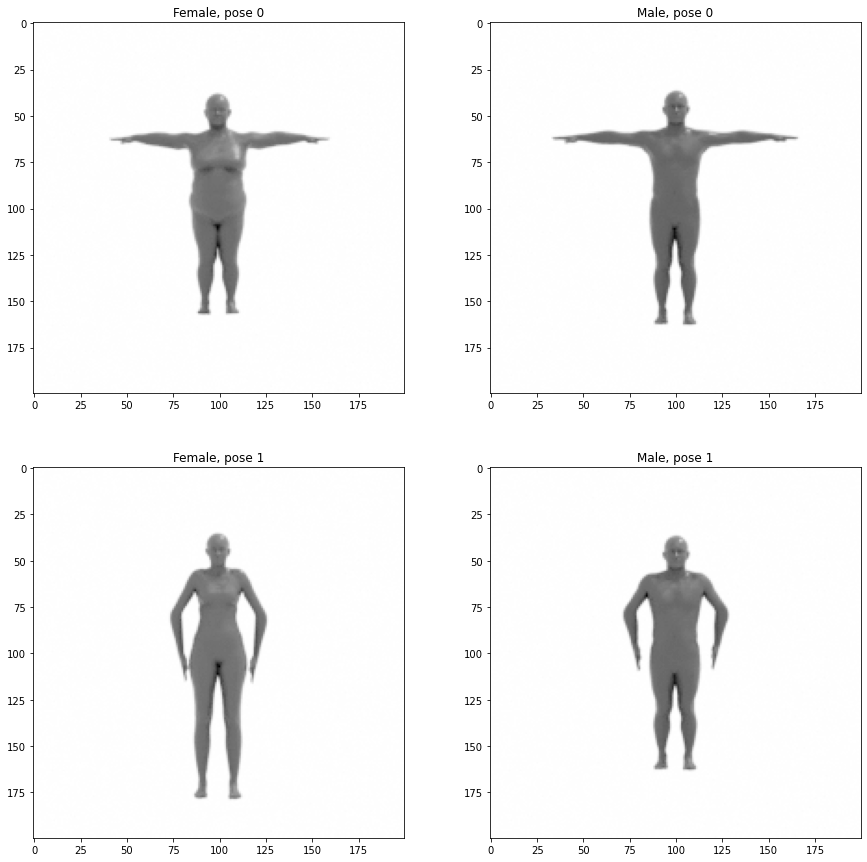

In [11]:
# Review data
plt.figure(figsize=(15, 15))
plt.subplot(221), plt.imshow(im_data[0], cmap='gray'), plt.title("Female, pose 0")
plt.subplot(222), plt.imshow(im_data[3001], cmap='gray'), plt.title("Male, pose 0")
plt.subplot(223), plt.imshow(im_data[6001], cmap='gray'), plt.title("Female, pose 1")
plt.subplot(224), plt.imshow(im_data[9001], cmap='gray'), plt.title("Male, pose 1")

# Prepare occluded images

In [12]:
# Load occluded images from file or generate them
if os.path.exists(FULL_DATA_WITH_OCCLUSIONS_NP_ARRAY_PATH):
    im_data_occl = np.load(FULL_DATA_WITH_OCCLUSIONS_NP_ARRAY_PATH)

else:
    # Seed pseudo-random number generator for reproducibility
    random.seed(a="HBDE from occluded images", version=2)

    # Add rectangles to images
    im_data_occl = []
    for img_np in im_data:
        # Determine position, length and width of occluding rectangle
        upper_left_x = random.randrange(0, 200)
        upper_left_y = random.randrange(0, 200)
        lower_right_x = upper_left_x + random.randrange(0, 50)
        lower_right_y = upper_left_y + random.randrange(0, 50)

        # Convert from NumPy array to instance of Pillow Image class
        img = Image.fromarray(img_np)

        # Draw rectangles
        draw = ImageDraw.Draw(img)
        draw.rectangle((upper_left_x, upper_left_y, lower_right_x, lower_right_y), fill="black")

        # Add manipulated image to array of occluded images
        im_data_occl.append(np.asarray(img))
        
    im_data_occl = np.array(im_data_occl)
    with open(FULL_DATA_WITH_OCCLUSIONS_NP_ARRAY_PATH, "wb+") as f:
        np.save(f, im_data)
    f.close()

if not im_data.shape == (12000, 200, 200):
    print("Problems with image data.")
    exit()

(<AxesSubplot:title={'center':'Male, pose 1'}>,
 Text(0.5, 1.0, 'Male, pose 1'))

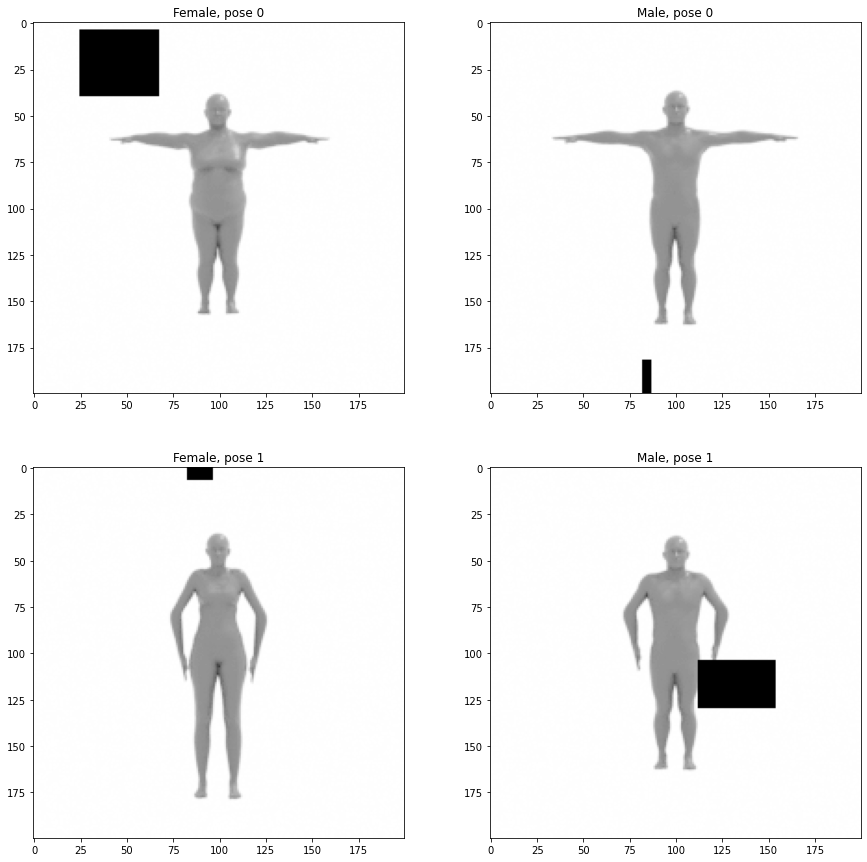

In [13]:
# Review data
plt.figure(figsize=(15, 15))
plt.subplot(221), plt.imshow(im_data_occl[0], cmap='gray'), plt.title("Female, pose 0")
plt.subplot(222), plt.imshow(im_data_occl[3001], cmap='gray'), plt.title("Male, pose 0")
plt.subplot(223), plt.imshow(im_data_occl[6001], cmap='gray'), plt.title("Female, pose 1")
plt.subplot(224), plt.imshow(im_data_occl[9001], cmap='gray'), plt.title("Male, pose 1")